<a href="https://colab.research.google.com/github/orcorsetti/labo2025v/blob/main/src/rpart/102_FinalTrain_Ganancia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Arbol elemental con libreria  rpart

## Introduccion

Este es el primer notebook/script de la materia Laboratorio de Implementacion I, se expone en la primera clase.
<br>Se utilizan Arboles de Decision, librería **rpart**,  el primer algoritmo, el más simple que utilizaremos en la materia pero que es el fundamento de los Ensembles de Arboles de Decision tales como  Random Forest y  Gradient Boosting of Decision Trees (XGBoost/LightGBM)
<br>La materia posee un dataset con 31 meses, en las primeras clases toda la cohorte, independiente de la modalidad elegida, utilizará **dataset_pequeno** que posee apenas un mes histórico 202107 y obviamente el mes donde se debe realizar la predicción 202109
<br>Este primer notebook/script **no** desarrolla todas las etapas necesarias para la generación de un buen modelo, apenas posee la parte final del pipeline/workflow.

### Limitaciones



Este primer y elemental notebook/script supone estas simplificaciónes:
* Solo se dispone del mes 202107 con el campo clase_ternaria completo, es el unico mes donde entrenar
* Se decidió previamente, de alguna forma, que la etapa de Final Training se hará sobre TODO el dataset de 202107
* Se obtuvieron previamente los hiperparámetros optimos de la libería **rpart** para este problema, mediante algun tipo de busqueda búsqueda.  Esta es la etapa que demandará decenas de horas para quienes opten por la *modalidad Analista Senior*
* No se realiza ningun tipo de feature engineering intra-mes
* Al no disponer de datos históricos no se realiza ningun tipo de feature engineering histórico
* No hay ningun analisis de la calidad de los campos, no se analiza si ocurrió alguna catástrofe ese mes y algun campo no se calculó correctamente
* Noy hay ningun tipo de análisis de Data Drifting entre los meses de 202107 y 202109
* Obedientemente se trabaja utlizando como clase el campo **clase_ternaria** sin ningun tipo de transformacion


<br> Obviamente, a lo largo de la materia se avanzará sobre todas las limitacinoes anteriores.

## Seteo del ambiente en Google Colab

Esta parte se debe correr con el runtime en Python3
<br>Ir al menu, Runtime -> Change Runtime Tipe -> Runtime type ->  **Python 3**

Conectar la virtual machine donde esta corriendo Google Colab con el  Google Drive, para poder tener persistencia de archivos

In [ ]:
# primero establecer el Runtime de Python 3
from google.colab import drive
drive.mount('/content/.drive')

Drive already mounted at /content/.drive; to attempt to forcibly remount, call drive.mount("/content/.drive", force_remount=True).


Para correr la siguiente celda es fundamental en Arranque en Frio haber copiado el archivo kaggle.json al Google Drive, en la carpeta indicada en el instructivo

<br>los siguientes comando estan en shell script de Linux
*   Crear las carpetas en el Google Drive
*   "instalar" el archivo kaggle.json desde el Google Drive a la virtual machine para que pueda ser utilizado por la libreria  kaggle de Python
*   Bajar el  **dataset_pequeno**  al  Google Drive  y tambien al disco local de la virtual machine que esta corriendo Google Colab



In [ ]:
%%shell

mkdir -p "/content/.drive/My Drive/labo1"
mkdir -p "/content/buckets"
ln -s "/content/.drive/My Drive/labo1" /content/buckets/b1

mkdir -p ~/.kaggle
cp /content/buckets/b1/kaggle/kaggle.json  ~/.kaggle
chmod 600 ~/.kaggle/kaggle.json


mkdir -p /content/buckets/b1/exp
mkdir -p /content/buckets/b1/datasets
mkdir -p /content/datasets



archivo_origen="https://storage.googleapis.com/open-courses/austral2025-af91/dataset_pequeno.csv"
archivo_destino="/content/datasets/dataset_pequeno.csv"
archivo_destino_bucket="/content/buckets/b1/datasets/dataset_pequeno.csv"

if ! test -f $archivo_destino_bucket; then
  wget  $archivo_origen  -O $archivo_destino_bucket
fi


if ! test -f $archivo_destino; then
  cp  $archivo_destino_bucket  $archivo_destino
fi


ln: failed to create symbolic link '/content/buckets/b1/labo1': File exists


In [1]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

# cargo las librerias que necesito
require("data.table")
require("rpart")
if (!require("rpart.plot")) install.packages("rpart.plot")
require("rpart.plot")

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,657308,35.2,1454477,77.7,1380129,73.8
Vcells,1220422,9.4,8388608,64.0,1975128,15.1


Loading required package: data.table

Loading required package: rpart

Loading required package: rpart.plot

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘rpart.plot’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: rpart.plot



In [10]:
id  <- "1c1ZlJ2szjDRPwzKSvM2pWWb7N4a-ltYz"
url <- sprintf("https://docs.google.com/uc?id=%s&export=download", id)

df <- read.table(
  url,
  header = TRUE,
  sep = ",",
  fill = TRUE,
  comment.char = "",
  blank.lines.skip = TRUE,
  strip.white = TRUE,
  row.names = NULL,
  check.names = TRUE
)

nrow(df)
head(df)

library(dplyr)
library(readr)

# Helper para convertir a numérico con coma decimal
numize <- function(x) parse_number(as.character(x),
                                   locale = locale(decimal_mark = ",",
                                                   grouping_mark = "."))

df_clean <- df %>%
  mutate(
    cp          = numize(cp),
    maxdepth    = numize(maxdepth),
    minsplit    = numize(minsplit),
    minbucket   = numize(minbucket),
    ganancia_test = numize(ganancia_test)
  )

# Ahora sí: mean por combinación de hiperparámetros
resumen_mean <- df_clean %>%
  group_by(cp, maxdepth, minsplit, minbucket) %>%
  summarise(
    ganancia_promedio = mean(ganancia_test, na.rm = TRUE),
    n = n(),
    .groups = "drop"
  )

head(resumen_mean)


[1] 14473

,semilla,cp,maxdepth,minsplit,minbucket,ganancia_test,Grupo
,<chr>,<chr>,<int>,<dbl>,<int>,<dbl>,<int>
1,500009,-1,14,30,20,27730000,1
2,500009,-0.5,14,30,20,27730000,1
3,500009,-1,14,50,20,29860000,1
4,500009,-0.5,14,50,20,29860000,1
5,500009,-1,14,30,17,30220000,1
6,500009,-0.5,14,30,17,30220000,1


cp,maxdepth,minsplit,minbucket,ganancia_promedio,n
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
-26,6,200,200,43950000,1
-26,6,200,500,44300000,1
-26,6,200,1000,42040000,1
-26,6,200,1500,41700000,1
-26,6,200,3000,41380000,1
-26,6,200,3500,40030000,1


In [13]:
param_final_lvl2 <- list (
  "cp"= -1, # complejidad minima
  "minsplit"= 50, # minima cantidad de regs en un nodo para hacer el split
  "minbucket"= 25, # minima cantidad de regs en una hoja
  "maxdepth"= 2 # profundidad máxima del arbol
)

param_final_lvl3 <- list (
  "cp"= -1, # complejidad minima
  "minsplit"= 50, # minima cantidad de regs en un nodo para hacer el split
  "minbucket"= 25, # minima cantidad de regs en una hoja
  "maxdepth"= 3 # profundidad máxima del arbol
)

### Training

In [14]:
# genero el modelo,  aqui se construye el arbol
# quiero predecir clase_ternaria a partir de el resto de las variables
modelo_final_lvl2 <- rpart(
    formula= "ganancia_promedio ~ .",
    data= resumen_mean, # los datos donde voy a entrenar
    xval=0,
    control= param_final_lvl2
)

# genero el modelo,  aqui se construye el arbol
# quiero predecir clase_ternaria a partir de el resto de las variables
modelo_final_lvl3 <- rpart(
    formula= "ganancia_promedio ~ .",
    data= resumen_mean, # los datos donde voy a entrenar
    xval=0,
    control= param_final_lvl3
)

#### Impresion del modelo

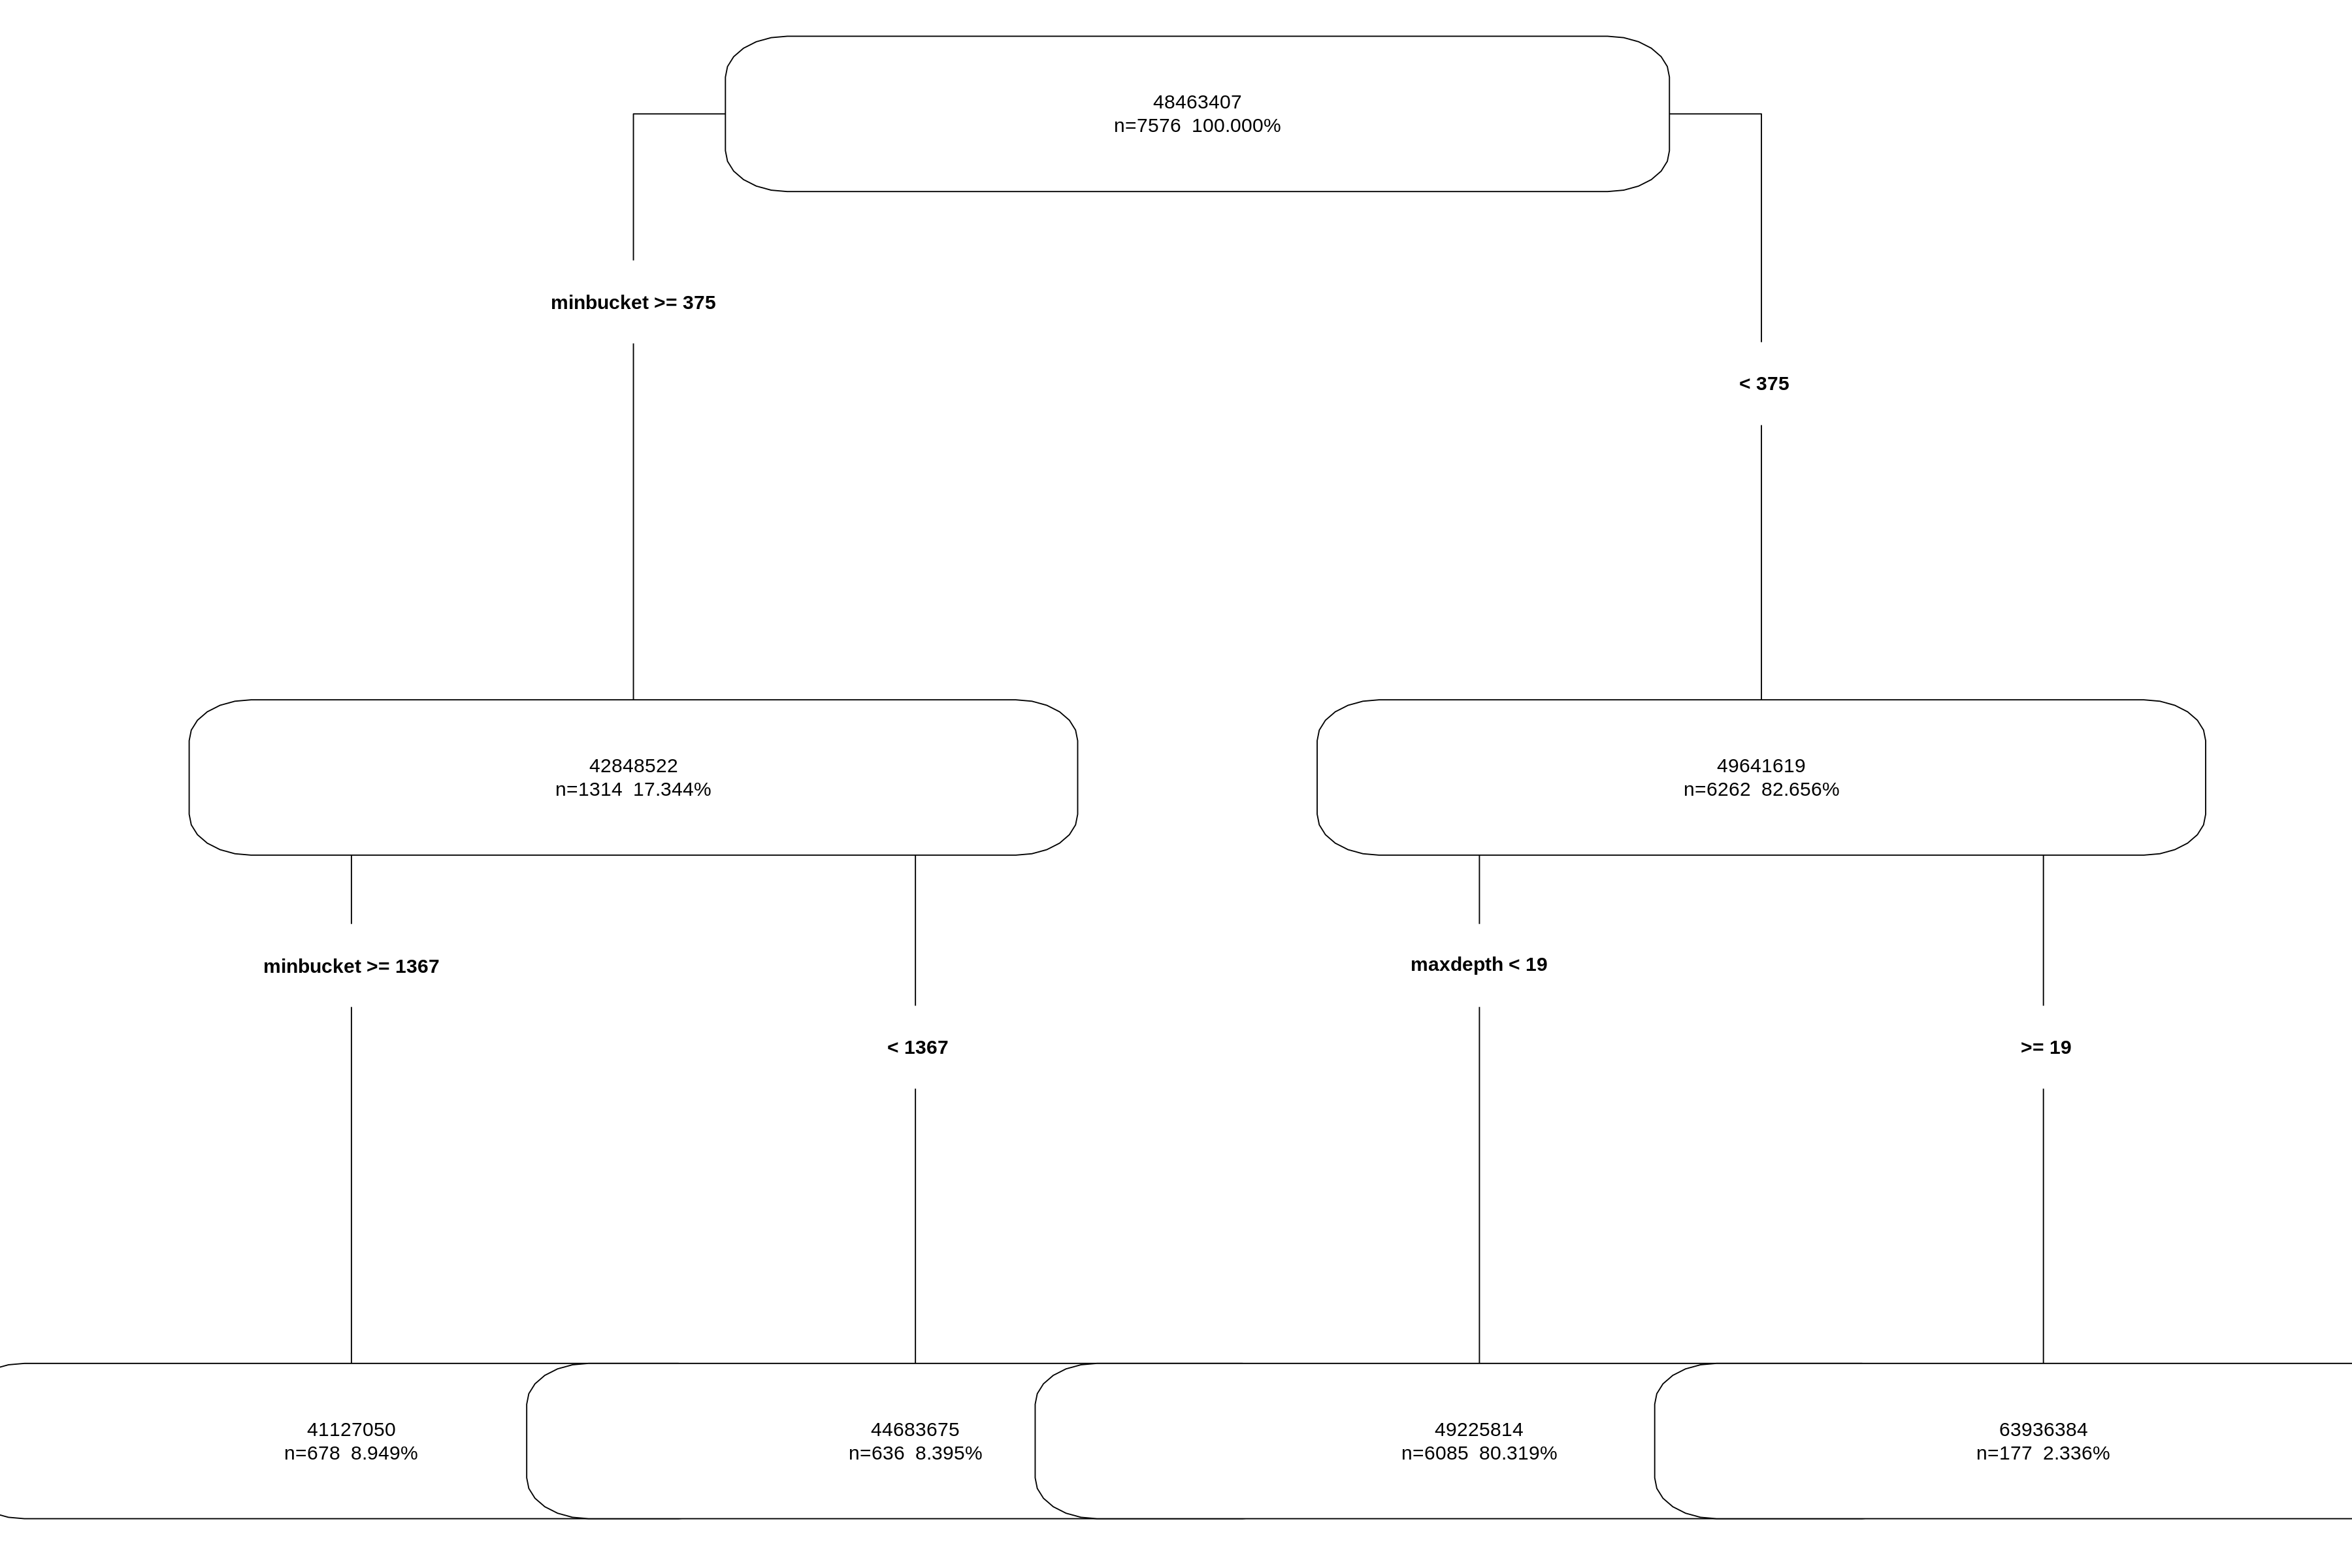

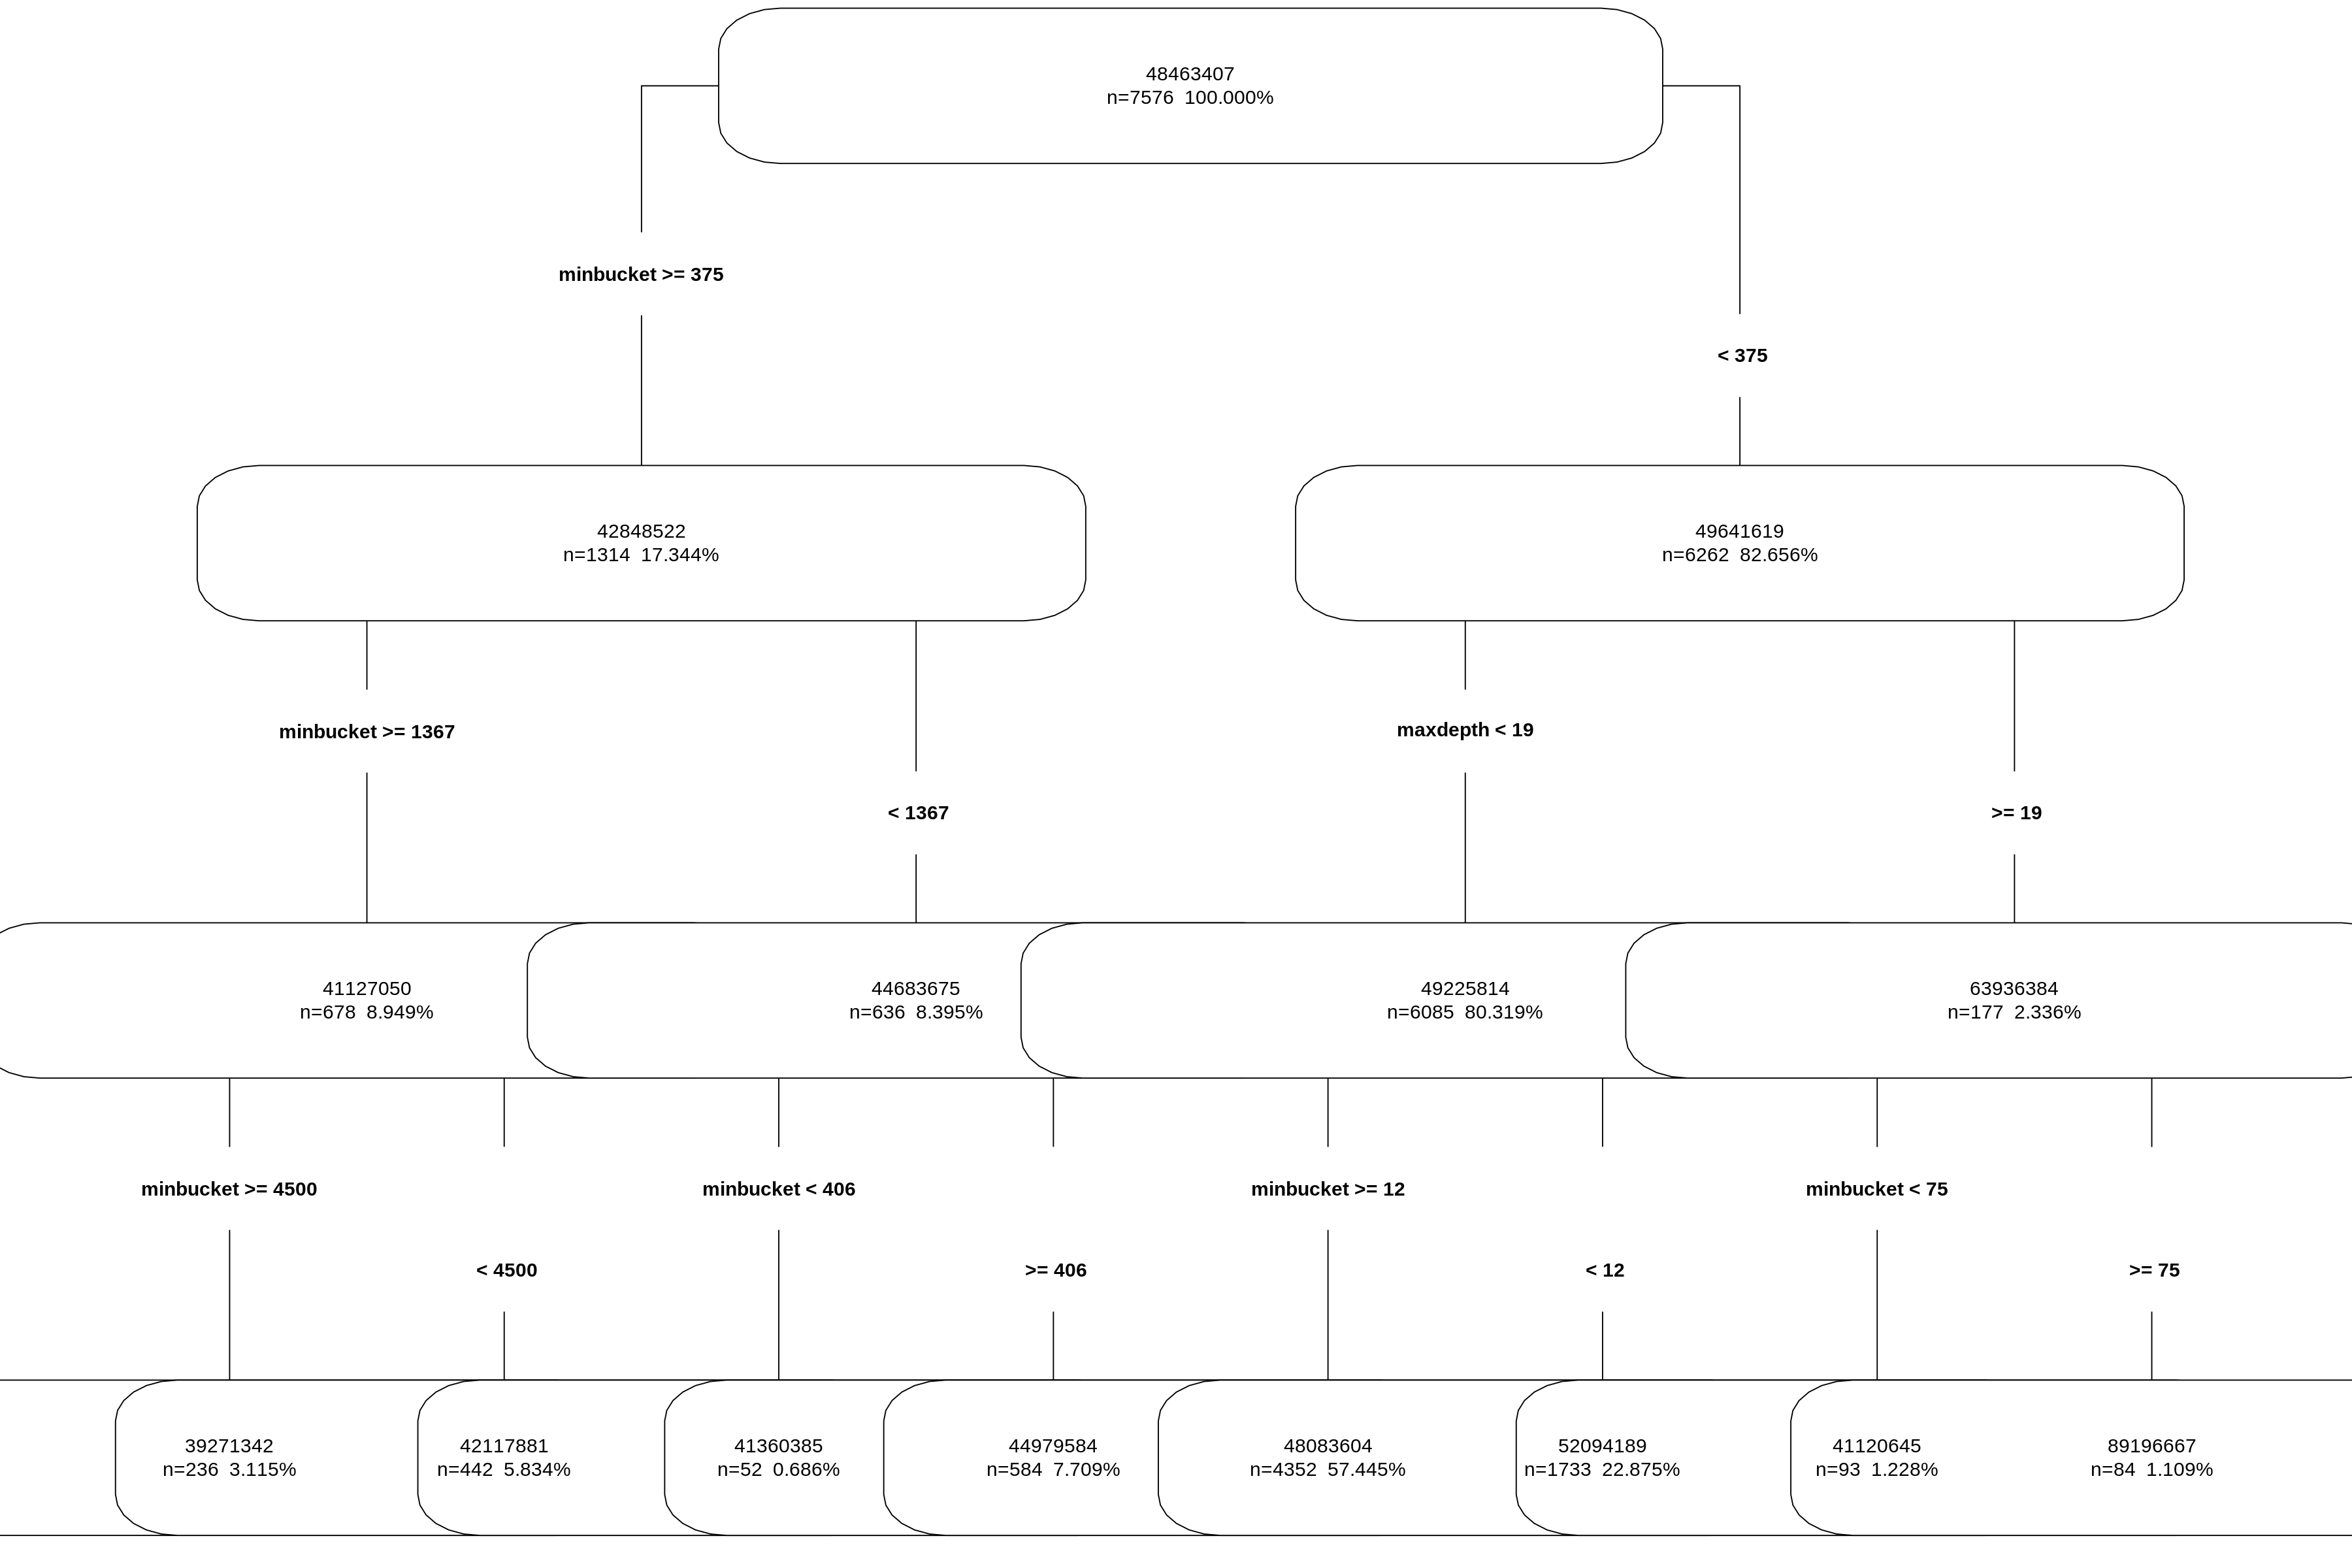

In [15]:
# grafico el arbol
options(repr.plot.width=30, repr.plot.height=20 )

prp(modelo_final_lvl2,
    extra= 101,
    digits= -5,
    branch= 1,
    type= 4,
    varlen= 0,
    faclen= 0,
    cex=1.5
)

options(repr.plot.width=30, repr.plot.height=20 )

prp(modelo_final_lvl3,
    extra= 101,
    digits= -5,
    branch= 1,
    type= 4,
    varlen= 0,
    faclen= 0,
    cex=1.5
)

## Tarea para el Hogar

Explorar manualmente que hiperparámetros genera una mayor ganancia en Kaggle
<br> Si en un momento logra quedar en primera posición del Private Leaderboard, saquese una selfie